In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_palette('muted')

# Unsupervised ML - Segmentation of Mall customers

### EDA

In [33]:
df_raw = pd.read_csv('Mall_Customers.csv')

In [34]:
df_raw.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [35]:
#remove ID-col - no need for it

df = df_raw.drop(columns=['CustomerID'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


No nulls, 200 rows

In [50]:
df['Gender'] = df['Gender'].astype("category")

### Numerical features

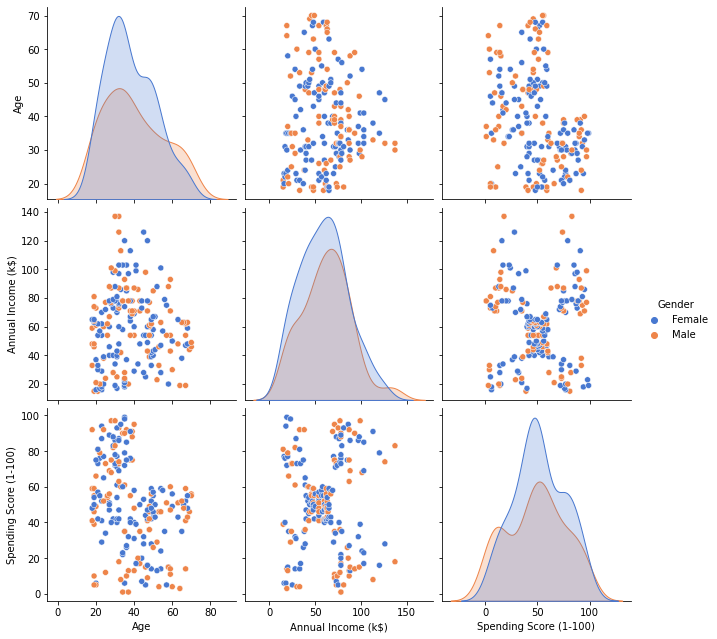

In [106]:
sns.pairplot(df, hue='Gender', height=3);

No major outliers, also not easy to visually see correlations between numerical features

### Categorical features (gender only)

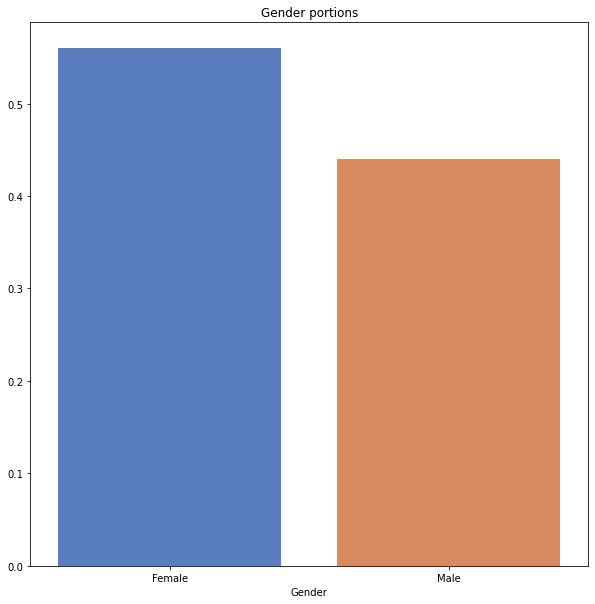

In [109]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10))

data = df.groupby(by='Gender')['Age'].count()
data = data / data.sum()

sns.barplot(x=data.index, y = data.values)
plt.title('Gender portions');

Gender-vise data in decent balance

### K.means Clustering in order to find customers segments to focus marketing efforts to

In [82]:
### Feature scaling and Onehot-encoding of categorical features

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Onehot
cat_cols = df.select_dtypes(include='category')
cat_names = cat_cols.columns

encoder = OneHotEncoder(handle_unknown='ignore')

onehot_cols = pd.DataFrame.sparse.from_spmatrix(encoder.fit_transform(df[cat_names]), columns = encoder.get_feature_names(cat_names))

### Scaling
num_cols = df.select_dtypes(include='int64')
num_names = num_cols.columns

scaler = StandardScaler()

scaled_cols = pd.DataFrame(scaler.fit_transform(df[num_names]), columns = num_names)

In [86]:
X = pd.concat([onehot_cols, scaled_cols], axis=1)

### Select number of clusters

In [103]:
from sklearn.cluster import KMeans

c_max = 20

inertia = []

for c in range(c_max):
    
    kmeans = KMeans(n_clusters=c+1).fit(X)
    inertia.append(kmeans.inertia_)
    

C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataF

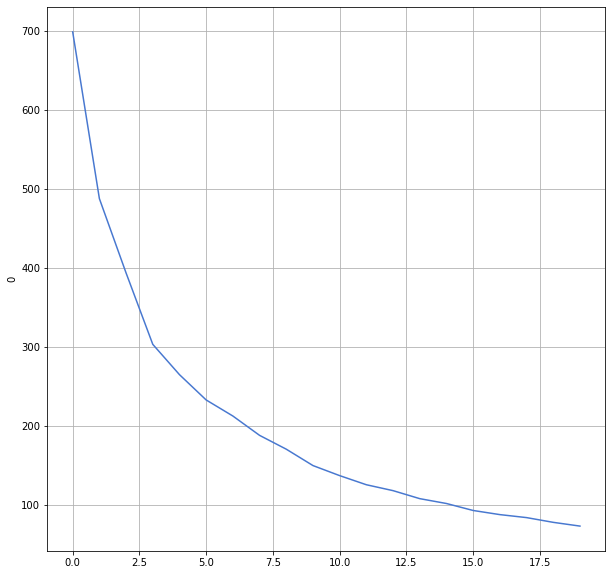

In [111]:
data = pd.DataFrame(inertia)

figure(figsize=(10, 10))

sns.lineplot(x=data.index, y=data[0], data=data)
plt.grid()

### Considering both the elbow method and what is practical in this use case, we select c=5

In [112]:
kmeans = KMeans(n_clusters=5).fit(X)

C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [114]:
clustering = pd.DataFrame(kmeans.predict(X))

C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [121]:
df_final = pd.concat([df,clustering], axis=1).rename(columns={0:'Cluster'})

### Visualization of results in terms of Spending score and Annual Income

In [123]:
df_final.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,2
1,Male,21,15,81,2
2,Female,20,16,6,3
3,Female,23,16,77,2
4,Female,31,17,40,3


<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

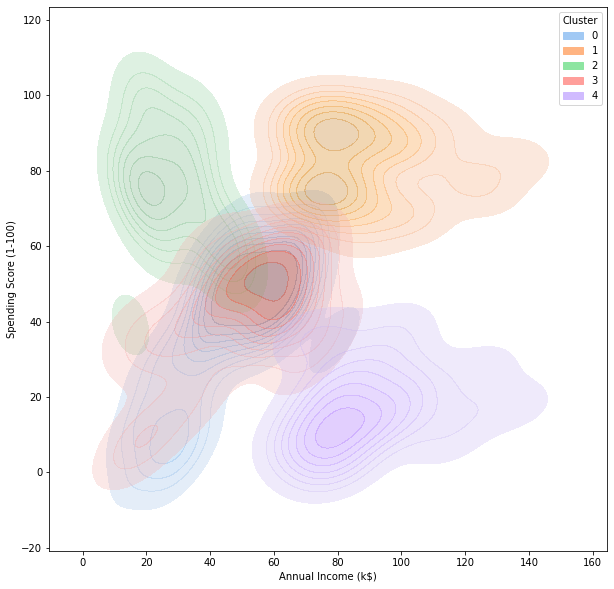

In [133]:
fig, ax = plt.subplots(figsize=(10,10))

#sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)', data=df_final, hue='Cluster', palette='pastel' )
sns.kdeplot(x='Annual Income (k$)',y='Spending Score (1-100)', data=df_final, hue='Cluster', fill=True,alpha=0.3, palette='pastel' )


In terms of Mall Marketing efforts, clusters 2 and 1 would be most beneficial to focus on. <br> Cluster 1 is buying a lot, but maybe a bit cheaper products. <br>Cluster 2 is also buying a alot, but have more money to spend

### PCA for fun

In [135]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)

C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\HUS67557620\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [137]:
X_pca.shape

(200, 2)

Text(0.5, 1.0, 'Clusters after PCA')

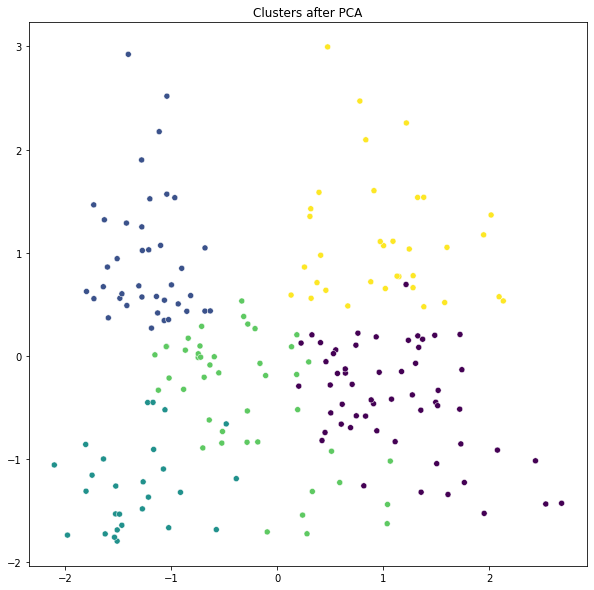

In [141]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], c=clustering)
ax.set_title('Clusters after PCA')

In [144]:
pca.explained_variance_ratio_

array([0.38132566, 0.28707805])